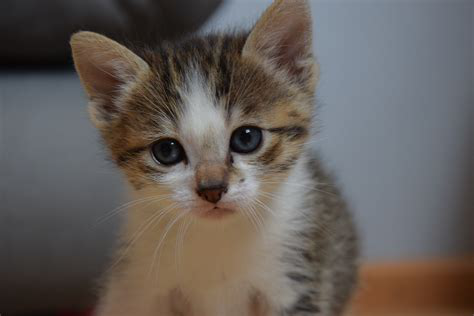

In [38]:
from PIL import Image
img = Image.open('data/cat_dog/cat/1.png')
img

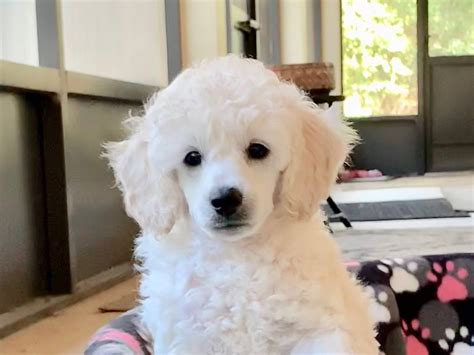

In [39]:
img = Image.open('data/cat_dog/dog/1.png')
img

In [40]:
from torchvision import transforms
import torchvision
# preprocessing of images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# preprocessing and labeling
dataset = torchvision.datasets.ImageFolder('data/cat_dog/', transform)
dataset

Dataset ImageFolder
    Number of datapoints: 200
    Root location: data/cat_dog/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [41]:
# check of first sample
# (x, t)
dataset[0]

(tensor([[[ 1.1187,  0.9988,  0.9646,  ...,  1.5982,  1.6153,  1.7009],
          [ 1.0502,  0.9646,  0.9474,  ...,  1.3413,  1.3413,  1.4269],
          [ 1.0331,  0.9646,  0.9646,  ...,  1.4098,  1.4269,  1.5125],
          ...,
          [ 0.2282,  0.1939,  0.1939,  ...,  0.0912,  0.0912,  0.1083],
          [ 0.2624,  0.2282,  0.2111,  ...,  0.1426,  0.1426,  0.1939],
          [ 0.3138,  0.2796,  0.2624,  ...,  0.2453,  0.2282,  0.2967]],
 
         [[ 0.9580,  0.8880,  0.8880,  ...,  1.6583,  1.6758,  1.7633],
          [ 0.9055,  0.8529,  0.8880,  ...,  1.4132,  1.4307,  1.5182],
          [ 0.9230,  0.8880,  0.9230,  ...,  1.4832,  1.5007,  1.5882],
          ...,
          [-0.4426, -0.4776, -0.4776,  ..., -0.4076, -0.4076, -0.3901],
          [-0.4076, -0.4426, -0.4776,  ..., -0.3550, -0.3550, -0.3025],
          [-0.3550, -0.4076, -0.4251,  ..., -0.2500, -0.2675, -0.1975]],
 
         [[ 1.1411,  1.1062,  1.1237,  ...,  1.9428,  1.9603,  2.0474],
          [ 1.1062,  1.0714,

In [50]:
import torch
import torch.utils.data

# train : val : test = 60% : 20% : 20%
n_train = int(len(dataset) * 0.6)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val

# split dataset
torch.manual_seed(0)
batch_size = 40
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

# prepare DataLoader
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [51]:
len(train)

120

In [52]:
import pytorch_lightning as pl
from torchvision.models import resnet18
import torch.nn as nn
import torchmetrics
import torch.nn.functional as F

class Net(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # feature extrantor(output: 1000 classes)
        self.feature_extractor = resnet18(weights=True)
        # fix learned parameters
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # fully conected layer
        self.fc = nn.Linear(1000, 2)

        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x):
        h = self.feature_extractor(x)
        h = self.fc(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc(y, t), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', self.val_acc(y, t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_acc(y, t), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', self.test_acc(y, t), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        return optimizer

In [53]:
# learning
pl.seed_everything(0)
net = Net()
trainer = pl.Trainer(max_epochs=10, gpus=0)
trainer.fit(net, train_loader, val_loader)

# test
results = trainer.test(net, test_loader)
results

Global seed set to 0
c:\Users\nagas\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\nagas\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type     | Params
---------------------------

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nagas\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\nagas\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nagas\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:1894: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 9: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it, loss=0.0283, v_num=31, train_acc_step=1.000, train_acc_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it, loss=0.0283, v_num=31, train_acc_step=1.000, train_acc_epoch=1.000]


c:\Users\nagas\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss           0.03756388649344444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03756388649344444, 'test_acc': 1.0}]